In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display
import io

# 1. Upload an image
from google.colab import files
uploaded = files.upload()

# 2. Load the uploaded image
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 3. Load pretrained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# 4. Prepare image for inference
img_tensor = F.to_tensor(img)

# 5. Run inference
with torch.no_grad():
    preds = model([img_tensor])[0]

# 6. Filter predictions
threshold = 0.5
scores = preds['scores'].numpy()
boxes = preds['boxes'].numpy()
labels = preds['labels'].numpy()

# COCO labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 7. Visualize results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i, score in enumerate(scores):
    if score > threshold:
        box = boxes[i]
        label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), width, height,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import time

# 🏷️ COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush','tomato'
]

# 📤 Upload image
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 🔄 Convert to tensor
img_tensor = F.to_tensor(img)

# 🎯 Load pre-trained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# ⏱️ Run inference
start_time = time.time()
with torch.no_grad():
    pred = model([img_tensor])[0]
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

# 📐 Image dimensions
img_width, img_height = img.size
left_limit = img_width * 0.45
right_limit = img_width * 0.55

# 🧮 Vehicle counters
vehicle_counts = {
    "car": 0,
    "truck": 0,
    "motorcycle": 0
}

# 🖼️ Display results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        label_idx = pred['labels'][i].item()
        label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

        if label in vehicle_counts:
            box = pred['boxes'][i].numpy()
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / 2

            if x_center < right_limit:
                vehicle_counts[label] += 1

                # 📦 Shrink the bounding box by 20%
                shrink_factor = 0.2
                box_width = x2 - x1
                box_height = y2 - y1
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2

                new_width = box_width * (1 - shrink_factor)
                new_height = box_height * (1 - shrink_factor)
                x1 = cx - new_width / 2
                x2 = cx + new_width / 2
                y1 = cy - new_height / 2
                y2 = cy + new_height / 2

                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='green', facecolor='none'))
                ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                        bbox=dict(facecolor='yellow', alpha=0.5))

# 🧾 Summary
total_detected = sum(vehicle_counts.values())
title_str = f"Vehicles(NORTHBOUND): {total_detected} | Inference: {inference_time:.2f}s"
plt.title(title_str)
plt.axis('off')
plt.show()

# 📊 Print breakdown
print("Vehicle breakdown (NORTHBOUND):")
for vehicle, count in vehicle_counts.items():
    print(f"{vehicle.title()}: {count}")
print(f"Total vehicles: {total_detected}")


KeyboardInterrupt: 

In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import time

# 🏷️ COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush','tomato'
]

# 📤 Upload image
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 🔄 Convert to tensor
img_tensor = F.to_tensor(img)

# 🎯 Load pre-trained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# ⏱️ Run inference
start_time = time.time()
with torch.no_grad():
    pred = model([img_tensor])[0]
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

# 📐 Image dimensions
img_width, img_height = img.size
left_limit = img_width * 0.45
right_limit = img_width * 0.55

# 🧮 Vehicle counters
vehicle_counts = {
    "car": 0,
    "truck": 0,
    "motorcycle": 0
}

# 🖼️ Display results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        label_idx = pred['labels'][i].item()
        label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

        if label in vehicle_counts:
            box = pred['boxes'][i].numpy()
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / 2

            if x_center < right_limit:
                vehicle_counts[label] += 1

                # 📦 Shrink the bounding box by 20%
                shrink_factor = 0.2
                box_width = x2 - x1
                box_height = y2 - y1
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2

                new_width = box_width * (1 - shrink_factor)
                new_height = box_height * (1 - shrink_factor)
                x1 = cx - new_width / 2
                x2 = cx + new_width / 2
                y1 = cy - new_height / 2
                y2 = cy + new_height / 2

                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='green', facecolor='none'))
                ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                        bbox=dict(facecolor='yellow', alpha=0.5))

# 🧾 Summary
total_detected = sum(vehicle_counts.values())
title_str = f"Vehicles(NORTHBOUND): {total_detected} | Inference: {inference_time:.2f}s"
plt.title(title_str)
plt.axis('off')
plt.show()

# 📊 Print breakdown
print("Vehicle breakdown (NORTHBOUND):")
for vehicle, count in vehicle_counts.items():
    print(f"{vehicle.title()}: {count}")
print(f"Total vehicles: {total_detected}")


ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import time

# 🏷️ COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush','tomato'
]

# 📤 Upload image
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 🔄 Convert to tensor
img_tensor = F.to_tensor(img)

# 🎯 Load pre-trained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# ⏱️ Run inference
start_time = time.time()
with torch.no_grad():
    pred = model([img_tensor])[0]
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

# 📐 Image dimensions
img_width, img_height = img.size
left_limit = img_width * 0.45
right_limit = img_width * 0.55

# 🧮 Vehicle counters
vehicle_counts = {
    "car": 0,
    "truck": 0,
    "motorcycle": 0
}

# 🖼️ Display results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        label_idx = pred['labels'][i].item()
        label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

        if label in vehicle_counts:
            box = pred['boxes'][i].numpy()
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / 2

            if x_center < right_limit:
                vehicle_counts[label] += 1

                # 📦 Shrink the bounding box by 20%
                shrink_factor = 0.2
                box_width = x2 - x1
                box_height = y2 - y1
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2

                new_width = box_width * (1 - shrink_factor)
                new_height = box_height * (1 - shrink_factor)
                x1 = cx - new_width / 2
                x2 = cx + new_width / 2
                y1 = cy - new_height / 2
                y2 = cy + new_height / 2

                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='green', facecolor='none'))
                ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                        bbox=dict(facecolor='yellow', alpha=0.5))

# 🧾 Summary
total_detected = sum(vehicle_counts.values())
title_str = f"Vehicles(NORTHBOUND): {total_detected} | Inference: {inference_time:.2f}s"
plt.title(title_str)
plt.axis('off')
plt.show()

# 📊 Print breakdown
print("Vehicle breakdown (NORTHBOUND):")
for vehicle, count in vehicle_counts.items():
    print(f"{vehicle.title()}: {count}")
print(f"Total vehicles: {total_detected}")


TypeError: 'NoneType' object is not subscriptable

Saving images-2.jpeg to images-2.jpeg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 151MB/s]


Inference time: 7.493 seconds


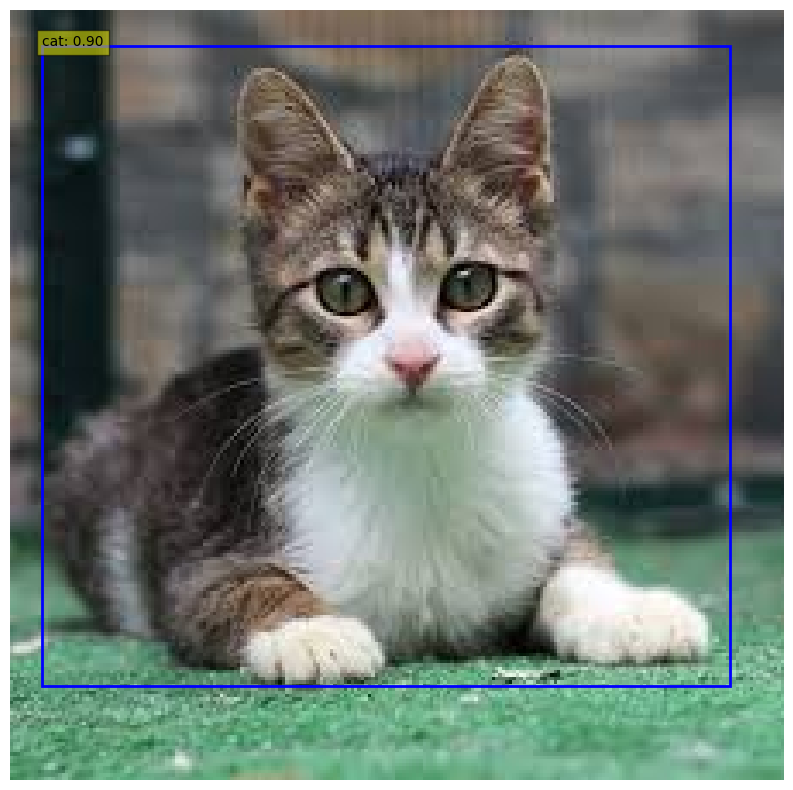

In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import time
import numpy as np

# 1. Upload an image
uploaded = files.upload()

# 2. Load the uploaded image
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 3. Load pretrained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# 4. Prepare image for inference
img_tensor = F.to_tensor(img)

# 5. Run inference and measure time
start_time = time.time()
with torch.no_grad():
    preds = model([img_tensor])[0]
end_time = time.time()
print(f"Inference time: {end_time - start_time:.3f} seconds")

# 6. Filter predictions
threshold = 0.5
scores = preds['scores'].cpu().numpy()
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()

# COCO labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 7. Visualize results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i, score in enumerate(scores):
    if score > threshold:
        box = boxes[i]
        label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), width, height,
                                 linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.tight_layout()
plt.show()
